This is based off of someones code to analysis music type

#https://github.com/Harbim001/Analysing_Nigerian_Music_Growth_Globally/blob/main/analysing_nigerian_music_growth_globally%20(1).py


In [1342]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, GlobalMaxPooling1D,ConvLSTM1D, MaxPooling1D, Flatten, LSTM
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error

import tensorflow as tf


import pickle

import pandas as pd
from pathlib import Path

path_to_dictionary_all_50 = "/Users/cslinxs/Desktop/all_weeks/summer24-lab/measurements_auscultatory_dictionary_ALL.pkl"

# Getting the Pikel file has the 50 point segmented
with open(path_to_dictionary_all_50, 'rb') as handle:
    all_auscultatory_50_segmented = pickle.load(handle)

# Some lists are filled with nans would be better to remove them
auscultatory_keys_with_nulls = []
for key, each_grouping in all_auscultatory_50_segmented.items():
    if True in list(np.isnan(each_grouping[0])):
        auscultatory_keys_with_nulls.append(key)
for key in auscultatory_keys_with_nulls:
    del all_auscultatory_50_segmented[key]


# Grouping people by their person ID
auscultatory_data_grouped_by_pid = {}
for key, each_grouping in list(all_auscultatory_50_segmented.items()):
    person_id = key.split("_")[1].split("/")[1]
    if not(person_id in auscultatory_data_grouped_by_pid):
        auscultatory_data_grouped_by_pid[person_id] = []
    auscultatory_data_grouped_by_pid[person_id].append({key: each_grouping})
         


First im going to split ppl if they have hyper tension or not

In [1343]:
# This gets the person
path_aurora_dataset = Path('/Users/cslinxs/Desktop/aurora_dataset/aurora_dataset/')

# This is getting the PID of ppl with Hypertenstion
participants_data =  path_aurora_dataset / "participants.tsv"
participants_csv_data = pd.read_csv(participants_data,sep = '\t')
participants_csv_htn = participants_csv_data[participants_csv_data["self_report_htn"].isin(["managed","unmanaged"])]
participants_csv_htn = participants_csv_htn[participants_csv_htn["pid"].str.contains('a')]
people_htn = participants_csv_htn["pid"]
people_htn

keys_for_grouping = [
"Calibration_start",#0
"Static_challenge_start",#1
"Seated_calibration",#2
"Static_seated_challenge",#3
"Exercise_challenge_start",#4
"Temporal_challenge_start",#5
"Temporal_seated_challenge"]#6
current_activity_key_used  = 6

 
def get_person_data(PID):
    return ([([each_data[0] for each_data in item.values()]) for item in auscultatory_data_grouped_by_pid[PID]], [([each_data[1] for each_data in item.values()][0]) for item in auscultatory_data_grouped_by_pid[PID]], [item.keys() for item in auscultatory_data_grouped_by_pid[PID]])

# This groups people by a feature
def get_person_data_group(diction, identifier):
    return ([([each_data[0] for each_data in item.values()]) for item in diction[identifier]], [([each_data[1] for each_data in item.values()][0]) for item in diction[identifier]], [item.keys() for item in diction[identifier]])

def get_person_split_data(dictionary_with_people):
    return ([item[0] for item in dictionary_with_people],[item[1] for item in dictionary_with_people],[item[2] for item in dictionary_with_people])

def get_person_data_group(diction, identifier):
    return ([([each_data[0] for each_data in item.values()]) for item in diction[identifier]], [([each_data[1] for each_data in item.values()][0]) for item in diction[identifier]], [item.keys() for item in diction[identifier]])


dict_people_ages = {}

for i in range(20,90,10):
    low_X = i
    participants_csv_data_age = participants_csv_data[participants_csv_data["age"].isin(list(range(i, i+10)))]
    participants_csv_data_age= participants_csv_data_age[participants_csv_data_age["pid"].str.contains('a')]
    #print(len(participants_csv_data_age["pid"]))
    dict_people_ages[str(i)] = participants_csv_data_age["pid"]
    

group_ppl_age = {}
dict_people_diseases ={}
for key, each_grouping in list(all_auscultatory_50_segmented.items()):
    person_id = key.split("_")[1].split("/")[1]
    # if person_id in list(people_htn):
    if "Static_challenge_start" in key:
        if not(person_id in group_ppl):
            group_ppl[person_id] = []
        group_ppl[person_id].append({key: each_grouping})
    
        for age_key, age_group in dict_people_ages.items():
            
            if  person_id in list(age_group):# and person_id in list(people_htn):
                if not(age_key in group_ppl_age):
                    group_ppl_age[age_key] = []


                group_ppl_age[age_key].append({key: each_grouping}) 


        
def get_people_with_hypertenstion():
    hyperstion_people = []
    non_hypertension_people = []
    all_people_charts = []
    for key, each_grouping in list(all_auscultatory_50_segmented.items()):

        if keys_for_grouping[current_activity_key_used] in key:

            person_id = key.split("_")[1].split("/")[1]
            if person_id in list(people_htn):
                hyperstion_people.append(each_grouping)
            else:
                non_hypertension_people.append(each_grouping)
            all_people_charts.append(each_grouping)
            
    return (hyperstion_people, non_hypertension_people, all_people_charts)


In [1393]:
people_with_hypertenstion = get_people_with_hypertenstion()[0]
people_with_out_hypertenstion = get_people_with_hypertenstion()[1]
all_people_data = get_people_with_hypertenstion()[2]




X = get_person_split_data(all_people_data)[0]
y = np.array(get_person_split_data(all_people_data)[1])
print((X))

# X1 = get_person_split_data(people_with_out_hypertenstion)[0]
# y1 = np.array(get_person_split_data(people_with_out_hypertenstion)[1])


[array([ 0.57025265,  1.6654674 , 12.46612155, 29.00976301, 43.19548266,
       53.21660117, 59.27719904, 61.49554373, 60.48263872, 57.80376713,
       54.55798263, 51.42870842, 48.76324394, 46.32473875, 43.33232438,
       39.5230713 , 35.78852276, 33.09135226, 31.95238714, 31.92354636,
       32.85836825, 34.02764841, 34.84334725, 34.99859283, 34.52456522,
       33.71418215, 32.46429661, 30.76059209, 28.89280778, 26.85661604,
       24.74823694, 22.74689466, 20.81300924, 18.99785511, 17.35065591,
       15.89916449, 14.64115419, 13.52828477, 12.61692267, 11.72926492,
       10.7780301 ,  9.67551144,  8.62148806,  7.44401173,  6.13062715,
        4.89934201,  3.68642138,  2.83501178,  2.09513568,  1.44036038]), array([ 0.33440294,  2.30997628, 16.53919689, 36.85637149, 52.12873974,
       62.01731253, 67.32328312, 68.57331321, 66.75016169, 63.27143478,
       59.69678008, 56.60208689, 54.28083607, 51.76107485, 48.60600649,
       45.08969157, 42.30754987, 41.03977344, 40.74248543, 41

In [1345]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
print(X.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(y_train.shape)

(1351, 50)
(1080, 1)


In [1349]:

def create_model():
    # model = Sequential()
    # model.add(Conv1D(filters=16, kernel_size=3,strides=3, activation='relu', input_shape=(X_train.shape[1], 1)))
    # model.add(Dropout(0.5))
    # model.add(Conv1D(64, kernel_size=3, strides=3, activation='relu'))
    # model.add(Dropout(0.5))
    # model.add(Flatten())
    # model.add(Dense(1))
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=2,strides=2, activation='relu', input_shape=((X_train).shape[1], 1)))
    model.add(Dropout(0.5))
    model.add(Conv1D(64, kernel_size=5, strides=5, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Conv1D(128, kernel_size=3, strides=1, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    #model.add(Dense(1))
    
    optimizer = RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae',])

    return model



In [1350]:
model = create_model()
history = model.fit(X_train, y_train, epochs=25, validation_split=0.3)
model.summary()
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")

Epoch 1/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 15605.7129 - mae: 123.4279 - val_loss: 13838.1416 - val_mae: 116.0061
Epoch 2/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13623.1221 - mae: 114.0824 - val_loss: 9880.7666 - val_mae: 96.9138
Epoch 3/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10468.6982 - mae: 94.0757 - val_loss: 6207.0879 - val_mae: 74.2543
Epoch 4/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9217.1553 - mae: 83.4424 - val_loss: 5146.2334 - val_mae: 66.8277
Epoch 5/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9175.9541 - mae: 81.6526 - val_loss: 5204.5356 - val_mae: 67.9770
Epoch 6/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8807.6484 - mae: 78.6574 - val_loss: 4786.3916 - val_mae: 65.3199
Epoch 7/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8523.8682 - mae: 75.6583 - val_loss: 4681.4053 - val_mae: 64.9575
Epoch 8/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8381.9229 - mae: 74.0000 - val_loss: 3968.3330 - val_mae: 59.4521
E

Model: "sequential_333"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_848 (Conv1D)             │ (None, 25, 32)         │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_270 (Dropout)           │ (None, 25, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_849 (Conv1D)             │ (None, 5, 64)          │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_271 (Dropout)           │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_850 (Conv1D)             │ (None, 3, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_272 (Dropout)           │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_60 (Flatten)            │ (None, 384)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,210 (274.26 KB)

 Trainable params: 35,104 (137.12 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 35,106 (137.14 KB)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step - loss: 4062.3101 - mae: 61.1847
Test accuracy: 61.36094665527344


In [1324]:
print(y_train.shape)

(1080, 1)


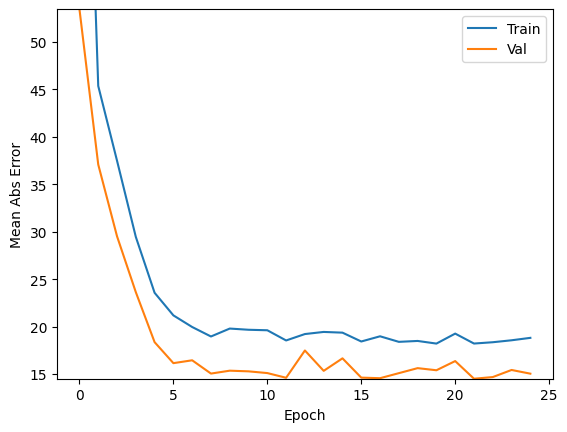

In [1348]:
def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(history.epoch, np.array(history.history['mae']), 
           label='Train')
  plt.plot(history.epoch, np.array(history.history['val_mae']),
           label = 'Val')
  plt.legend()
  plt.ylim([min(history.history['val_mae']),max(history.history['val_mae'])])
plot_history(history)



In [1270]:
print(history.history['mae'])

[122.76531219482422, 116.97338104248047, 105.38219451904297, 86.92511749267578, 63.17112731933594, 47.4858512878418, 43.107078552246094, 39.88325500488281, 37.21622848510742, 35.07013702392578, 32.39169692993164, 27.94699478149414, 24.637760162353516, 22.8046875, 21.566024780273438, 20.331663131713867, 19.541278839111328, 18.631284713745117, 18.519224166870117, 18.12425422668457, 18.84033966064453, 18.84759521484375, 18.026838302612305, 17.951435089111328, 18.16121482849121, 18.407974243164062, 18.510759353637695, 18.019071578979492, 18.125017166137695, 17.974246978759766, 17.34958839416504, 18.185440063476562, 17.803747177124023, 18.026416778564453, 17.65534019470215, 17.264041900634766, 17.954051971435547, 17.758039474487305, 18.074268341064453, 17.866552352905273, 18.098655700683594, 18.40717315673828, 17.795347213745117, 17.489620208740234, 17.496694564819336, 17.2498779296875, 17.212560653686523, 17.38581657409668, 17.7145938873291, 17.76481056213379]


In [1265]:
model.summary()

Model: "sequential_306"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_783 (Conv1D)             │ (None, 16, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_207 (Dropout)           │ (None, 16, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_784 (Conv1D)             │ (None, 5, 64)          │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_208 (Dropout)           │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_36 (Flatten)            │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_210 (Dense)               │ (None, 1)              │           321 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,044 (27.52 KB)

 Trainable params: 3,521 (13.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,523 (13.77 KB)

In [1266]:
from scipy import signal
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.model_selection import train_test_split

import pickle 
import matplotlib.colors

from sklearn.neighbors import KNeighborsRegressor

In [1269]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
print(X.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(y_train.shape)
def create_model():
    model = Sequential()
    model.add(Conv1D(filters=16, kernel_size=3,strides=3, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.5))
    model.add(Conv1D(64, kernel_size=3, strides=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(1))
    
    optimizer = RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae',])

    return model
model = create_model()
history = model.fit(X_train, y_train, epochs=50, validation_split=0.3)
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}", f"{}")

ValueError: Found array with dim 3. StandardScaler expected <= 2.

In [1334]:
#print(get_person_data_group(group_ppl_age,"20")[0])

[item[0] for item in get_person_data_group(group_ppl_age,"20")[0]]

[array([ 1.78135176,  4.26460265, 27.17391361, 54.4058613 , 73.88297707,
        89.0617198 , 97.11204822, 98.4246446 , 95.616649  , 91.78149646,
        88.56050636, 86.04175773, 84.0535484 , 82.25179707, 79.96121203,
        76.01173131, 70.16216518, 64.72263838, 61.63717616, 60.43287024,
        60.50464753, 61.8760256 , 63.16756652, 63.37322716, 62.52443293,
        60.78835875, 58.20981208, 55.10353163, 51.72220054, 47.93846029,
        44.10230824, 40.60775895, 37.72412286, 35.58713368, 33.54540541,
        31.42527864, 29.04804529, 26.70053985, 24.3300212 , 22.27445348,
        20.07733757, 18.19057859, 15.95199971, 13.86241471, 11.57382702,
         9.27884886,  6.42506872,  3.90373875,  2.15846682,  4.17716743]),
 array([ 0.32793843,  3.22907147, 18.32203506, 40.55891303, 62.89675124,
        79.25100447, 87.58360429, 88.52887983, 84.01682233, 78.44691363,
        74.19429921, 71.35551303, 69.49782871, 67.84959212, 65.64657209,
        62.21751984, 56.86839886, 51.24836793, 47

Epoch 1/50


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 12531.6963 - mae: 109.3049 - val_loss: 6794.8843 - val_mae: 77.1489
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6147.6133 - mae: 74.1252 - val_loss: 3926.5291 - val_mae: 52.9133
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3855.6667 - mae: 55.9781 - val_loss: 2990.2712 - val_mae: 44.6962
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2640.8164 - mae: 43.4993 - val_loss: 2908.0718 - val_mae: 43.2525
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2320.0479 - mae: 41.0593 - val_loss: 3081.9746 - val_mae: 44.8575
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2289.8625 - mae: 39.8321 - val_loss: 3153.9192 - val_mae: 45.4225
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2437.4719 - mae: 42.2062 - val_loss: 3027.9062 - val_mae: 44.4506
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2448.6531 - mae: 42.1747 - val_loss: 3133.8882 - val_mae: 45.2466
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━

/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_26055/418367169.py:112: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(age_keys)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_26055/418367169.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(age_keys)


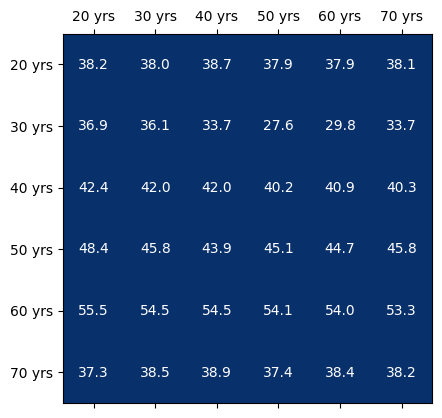

<Figure size 400x400 with 0 Axes>

In [1386]:
# heat plots

# single ones
#neigh = KNeighborsRegressor(n_neighbors=1)


all_age_mae= []
maxi_mean = 0
for training_age in range(20,80,10):
    training_age = str(training_age)

    this_age_mae = []
    for testing_age in range(20,80,10):
        testing_age= str(testing_age)
        


        #X = get_person_data_group(group_ppl_age,training_age)[0]
        # X = [item[0] for item in get_person_data_group(group_ppl_age,training_age)[0]]
        # y = get_person_data_group(group_ppl_age,training_age)[1]
        # print(y)
        # scaler = StandardScaler()
        # X = scaler.fit_transform(np.array(X))
        #print(X.shape)
        # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        # X_train= np.array(X_train)
       # print(y_train)


        X = get_person_data_group(group_ppl_age,training_age)[0]
        Y = get_person_data_group(group_ppl_age,training_age)[1]

        X_other = get_person_data_group(group_ppl_age,testing_age)[0]
        Y_other = get_person_data_group(group_ppl_age,testing_age)[1]
        



        tests_size = int(len(Y)*0.3)

        X_test= np.array(X)
        Y_test= np.array(Y)

        X_test = X_test.reshape(X_test.shape[0], -1)
        Y_test = Y_test.reshape(Y_test.shape[0], -1)

        X_train= np.array(X_other)
        Y_train= np.array(Y_other)

        X_train = X_test.reshape(X_test.shape[0], -1)
        Y_train = Y_test.reshape(Y_test.shape[0], -1)


        def create_model():
            # model = Sequential()
            # model.add(Conv1D(filters=16, kernel_size=3,strides=3, activation='relu', input_shape=((X_train).shape[1], 1)))
            # model.add(Dropout(0.5))
            # model.add(Conv1D(64, kernel_size=3, strides=3, activation='relu'))
            # model.add(Dropout(0.5))
            # model.add(Flatten())
            # model.add(Dense(1))
            

            model = Sequential()
            model.add(Conv1D(filters=32, kernel_size=2,strides=2, activation='relu', input_shape=((X_train).shape[1], 1)))
            model.add(Dropout(0.5))
            # model.add(Conv1D(64, kernel_size=5, strides=5, activation='relu'))
            # model.add(Dropout(0.5))
            # model.add(Conv1D(128, kernel_size=3, strides=1, activation='relu'))
            # model.add(Dropout(0.5))
            
            model.add(Flatten())
            model.add(Dense(1))


            optimizer = RMSprop(0.001)

            model.compile(loss='mse',
                        optimizer=optimizer,
                        metrics=['mae',])

            return model
        model = create_model()
        history = model.fit(X_train, tf.stack(Y_train), epochs=50, validation_split=0.3)
        test_loss, test_accuracy = model.evaluate(X_test,tf.stack(Y_test) )


        print(test_accuracy)
        this_age_mae.append(test_accuracy)

    if max(this_age_mae)>maxi_mean:
        maxi_mean= max(this_age_mae)
    all_age_mae.append(this_age_mae)








data = np.matrix(all_age_mae)

fig, ax = plt.subplots()
plt.figure(figsize=(4, 4)) 
cmap = matplotlib.colors.ListedColormap(['white','blue'])

# Using matshow here just because it sets the ticks up nicely. imshow is faster.
ax.matshow(data, cmap='Blues', vmin=0, vmax=15)
age_keys = [str(num)+" yrs" for num in range(10,90,10)]
plt.rcParams.update({'font.size': 10})
ax.set_xticklabels(age_keys)
ax.set_yticklabels(age_keys)

for (i, j), z in np.ndenumerate(data):
    ax.text(j, i, f"{round(z,1)}", ha='center', va='center', color = "white")
#bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3' )

plt.show()




In [1366]:
# I want a list
# of ppl with both hypertension and non
# then i want a list of the combo.
# maybe i can remove some of the hyper tensiton both and non bottom ato make a new list!!!

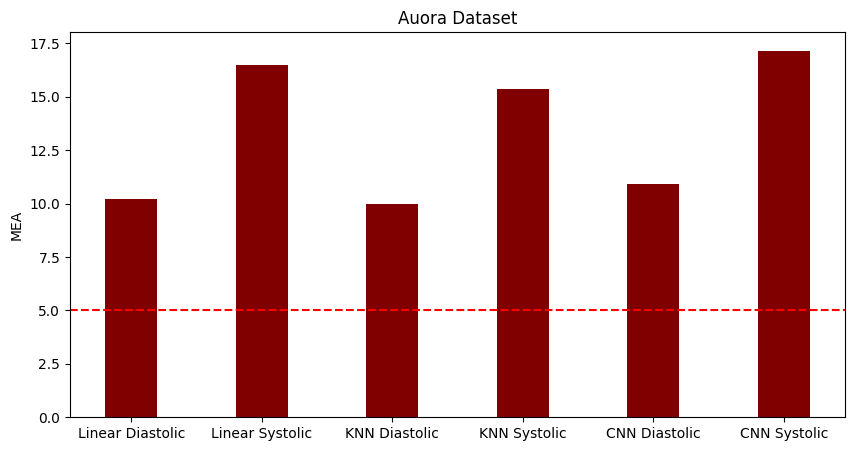

In [1418]:
# creating the dataset
data = {'Linear Diastolic':10.217,'Linear Systolic':16.49, 'KNN Diastolic':9.99, 'KNN Systolic':15.36, 'CNN Diastolic': 10.92,'CNN Systolic':17.152,
        }
courses = list(data.keys())
values = list(data.values())
 
fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(courses, values, color ='maroon', 
        width = 0.4)

plt.axhline(y=5, color='r', linestyle='--')

plt.ylabel("MEA")
plt.title("Auora Dataset")
plt.show()

In [1402]:
def get_stats(check_list):
    standard = float(np.std(check_list))
    mean = float(np.mean(check_list))
    return [min(check_list, default="EMPTY"),mean-standard-standard,mean-standard,mean,mean + standard,mean +standard+standard ,max(check_list) ]


In [1419]:
all_mea = []

for i in range(0,len(all_people_data),50): 



    X = get_person_split_data(all_people_data)[0][0:i] +get_person_split_data(all_people_data)[0][i+50:len(all_people_data)]
    Y = np.array(get_person_split_data(all_people_data)[2][0:i] +get_person_split_data(all_people_data)[2][i+50:len(all_people_data)])
    
    X_other = get_person_split_data(all_people_data)[0][i:i+50] 
    Y_other = np.array(get_person_split_data(all_people_data)[2][i:i+50])


    tests_size = int(len(Y)*0.3)

    X_train= np.array(X)
    Y_train= np.array(Y)

    X_test = X_test.reshape(X_test.shape[0], -1)
    Y_test = Y_test.reshape(Y_test.shape[0], -1)

    X_test= np.array(X_other)
    Y_test= np.array(Y_other)

    X_train = X_test.reshape(X_test.shape[0], -1)
    Y_train = Y_test.reshape(Y_test.shape[0], -1)


    def create_model():
        model = Sequential()
        model.add(Conv1D(filters=16, kernel_size=3,strides=3, activation='relu', input_shape=((X_train).shape[1], 1)))
        model.add(Dropout(0.5))
        model.add(Conv1D(64, kernel_size=3, strides=3, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Flatten())
        model.add(Dense(1))


        optimizer = RMSprop(0.001)

        model.compile(loss='mse',
                    optimizer=optimizer,
                    metrics=['mae',])

        return model
    model = create_model()
    history = model.fit(X_train, tf.stack(Y_train), epochs=50, validation_split=0.3)
    test_loss, test_accuracy = model.evaluate(X_test,tf.stack(Y_test) )


    all_mea.append(test_accuracy)

Epoch 1/50


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 5468.8257 - mae: 70.7138 - val_loss: 3625.2422 - val_mae: 57.9977
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4056.2083 - mae: 59.0983 - val_loss: 2659.3726 - val_mae: 47.0140
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3265.7952 - mae: 52.5202 - val_loss: 2154.2673 - val_mae: 42.1137
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2182.2036 - mae: 42.3875 - val_loss: 1991.9823 - val_mae: 40.9821
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1630.8417 - mae: 35.1055 - val_loss: 1997.9205 - val_mae: 40.4127
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1390.1449 - mae: 31.7832 - val_loss: 2049.3489 - val_mae: 40.5702
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1623.0239 - mae: 32.6898 - val_loss: 2073.9299 - val_mae: 40.6467
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1543.4905 - mae: 32.0623 - val_loss: 2181.1611 - val_mae: 41.0848
Epoch 9/50
2/2 ━━━━━━━━━━━━

ValueError: Training data contains 1 samples, which is not sufficient to split it into a validation and training set as specified by `validation_split=0.3`. Either provide more data, or a different value for the `validation_split` argument.

10.923760482243129

In [1408]:

print(get_stats(all_mea)[3])
print(get_stats(all_mea)[4] - get_stats(all_mea)[3])

10.923760482243129
1.270130623910445
